In [1]:
!pip install -U awscli
!pip install sagemaker

In [2]:
%matplotlib inline

import time
import os
import boto3
import botocore
import re
import json
from datetime import datetime, timedelta, timezone
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name

# You can use a different IAM role with "SageMakerFullAccess" policy for this notebook
role = get_execution_role()
print(f"Execution role: {role}")

sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = "final-exam-bucket01"
prefix = "sagemaker/DEMO-Deployment-Guardrails-Canary"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Execution role: arn:aws:iam::692885108950:role/LabRole
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
model_url = S3Uploader.upload(
    local_path="model/model1.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)
model_url2 = S3Uploader.upload(
    local_path="model/model2.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)

print(f"Model URI 1: {model_url}")
print(f"Model URI 2: {model_url2}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Model URI 1: s3://final-exam-bucket01/sagemaker/DEMO-Deployment-Guardrails-Canary/model1.tar.gz
Model URI 2: s3://final-exam-bucket01/sagemaker/DEMO-Deployment-Guardrails-Canary/model2.tar.gz


Note: Linear learner only has "version 1"

In [4]:
from sagemaker import image_uris

image_uri = image_uris.retrieve("linear-learner", boto3.Session().region_name, "1")
image_uri2 = image_uris.retrieve("linear-learner", boto3.Session().region_name, "1")
image_uri3 = image_uris.retrieve("linear-learner", boto3.Session().region_name, "1")

print(f"Model Image 1: {image_uri}")
print(f"Model Image 2: {image_uri2}")
print(f"Model Image 3: {image_uri3}")

Model Image 1: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1
Model Image 2: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1
Model Image 3: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [5]:
model_name = f"DEMO-linear-learner-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-linear-learner-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name3 = f"DEMO-linear-learner-pred3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Model Name 1: {model_name}")
print(f"Model Name 2: {model_name2}")
print(f"Model Name 3: {model_name3}")

resp = sm.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, "ModelDataUrl": model_url}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri2, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name3,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri3, "ModelDataUrl": model_url}],
)
print(f"Created Model: {resp}")

Model Name 1: DEMO-linear-learner-pred-2023-12-13-00-40-13
Model Name 2: DEMO-linear-learner-pred2-2023-12-13-00-40-13
Model Name 3: DEMO-linear-learner-pred3-2023-12-13-00-40-13
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:692885108950:model/demo-linear-learner-pred-2023-12-13-00-40-13', 'ResponseMetadata': {'RequestId': 'ccc7036b-fa46-4d43-b2f7-ec151547b25c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ccc7036b-fa46-4d43-b2f7-ec151547b25c', 'content-type': 'application/x-amz-json-1.1', 'content-length': '106', 'date': 'Wed, 13 Dec 2023 00:40:13 GMT'}, 'RetryAttempts': 0}}
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:692885108950:model/demo-linear-learner-pred2-2023-12-13-00-40-13', 'ResponseMetadata': {'RequestId': '040e1a2d-00da-4859-8698-11428bee550c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '040e1a2d-00da-4859-8698-11428bee550c', 'content-type': 'application/x-amz-json-1.1', 'content-length': '107', 'date': 'Wed, 13 Dec 20

In [10]:
ep_config_name = f"DEMO-EpConfig-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name2 = f"DEMO-EpConfig-2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name3 = f"DEMO-EpConfig-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Endpoint Config 1: {ep_config_name}")
print(f"Endpoint Config 2: {ep_config_name2}")
print(f"Endpoint Config 3: {ep_config_name3}")

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name2,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name2,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name3,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

Endpoint Config 1: DEMO-EpConfig-1-2023-12-13-00-41-44
Endpoint Config 2: DEMO-EpConfig-2-2023-12-13-00-41-44
Endpoint Config 3: DEMO-EpConfig-3-2023-12-13-00-41-44
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint-config/demo-epconfig-1-2023-12-13-00-41-44', 'ResponseMetadata': {'RequestId': 'ba070a6d-1058-4b64-8ed0-7438d0b0de9e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ba070a6d-1058-4b64-8ed0-7438d0b0de9e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116', 'date': 'Wed, 13 Dec 2023 00:41:43 GMT'}, 'RetryAttempts': 0}}
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint-config/demo-epconfig-2-2023-12-13-00-41-44', 'ResponseMetadata': {'RequestId': 'fd2b55cf-7490-43d0-84c1-89b7fd99b54f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'fd2b55cf-7490-43d0-84c1-89b7fd99b54f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116'

In [11]:
endpoint_name = f"DEMO-Deployment-Guardrails-Canary-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Endpoint Name: {endpoint_name}")

resp = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=ep_config_name)
print(f"\nCreated Endpoint: {resp}")

Endpoint Name: DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00

Created Endpoint: {'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/demo-deployment-guardrails-canary-2023-12-13-00-42-00', 'ResponseMetadata': {'RequestId': '9efb19d1-1540-49c6-a9a0-e885df57c0f0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '9efb19d1-1540-49c6-a9a0-e885df57c0f0', 'content-type': 'application/x-amz-json-1.1', 'content-length': '121', 'date': 'Wed, 13 Dec 2023 00:41:59 GMT'}, 'RetryAttempts': 0}}


In [12]:
def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service

Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/demo-deployment-guardrails-canary-2023-12-13-00-42-00',
 'EndpointConfigName': 'DEMO-EpConfig-1-2023-12-13-00-41-44',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:ebb5ca517c1568776383de018e4c2d46e8b934284d40b9d2ddf5c2e37424c929',
     'ResolutionTime': datetime.datetime(2023, 12, 13, 0, 42, 1, 170000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 12, 13, 0, 42, 0, 404000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 12, 13, 0, 45, 7, 93000, tzinfo=tzlocal()),
 'ResponseM

In [27]:
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open("test_data/test-dataset.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e
            count += 1
            if count > max_invocations:
                break
            time.sleep(wait_interval_sec)

    print("\nDone!")

In [14]:
invoke_endpoint(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00. 
Please wait...
.................................................................................................
Done!


In [15]:
import pandas as pd

cw = boto3.Session().client("cloudwatch", region_name=region)


def get_sagemaker_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    if endpoint_config_name is not None:
        dimensions.append({"Name": "EndpointConfigName", "Value": endpoint_config_name})
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions,
    )
    rename = endpoint_config_name if endpoint_config_name is not None else "ALL"
    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: rename})
    )


def plot_endpoint_invocation_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=60)
    end_time = datetime.now(timezone.utc)
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    if metrics_variants is None:
        return
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

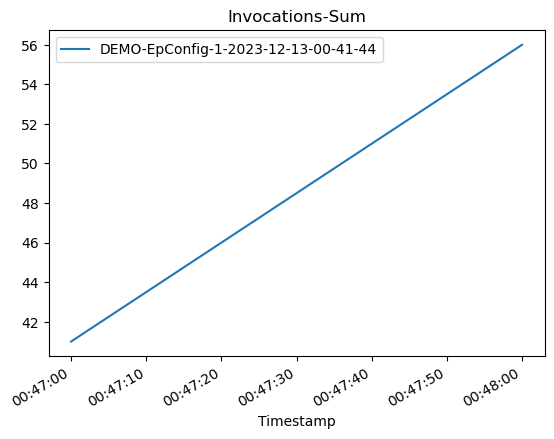

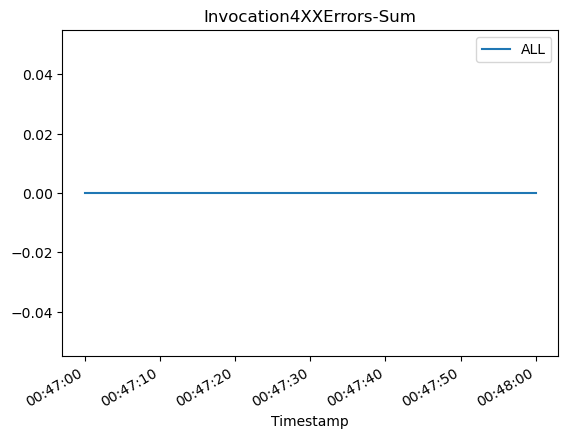

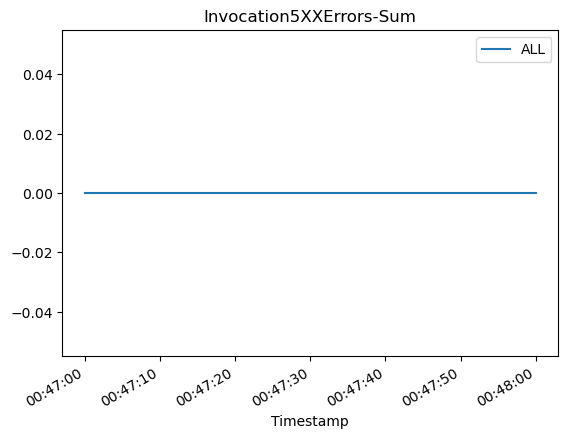

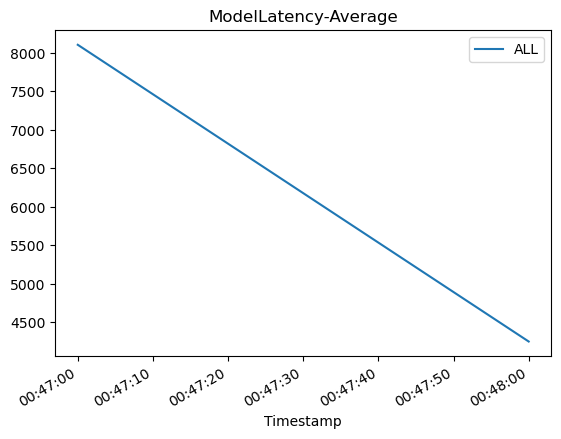

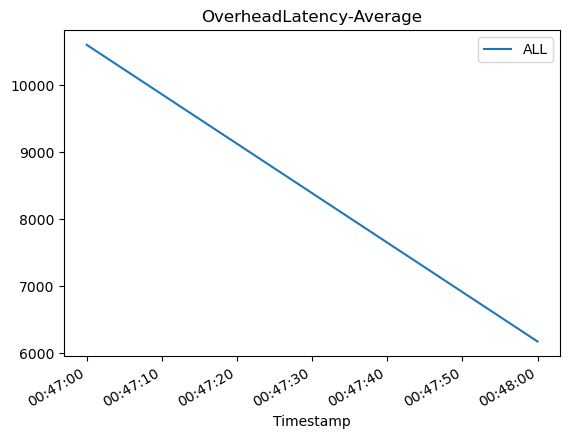

In [16]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

In [17]:
def create_auto_rollback_alarm(
    alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold
):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

In [18]:
error_alarm = f"TestAlarm-5XXErrors-{endpoint_name}"
latency_alarm = f"TestAlarm-ModelLatency-{endpoint_name}"

# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Average", 1
)
# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm(
    latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 10000
)

In [19]:
cw.describe_alarms(AlarmNames=[error_alarm, latency_alarm])
time.sleep(60)

In [20]:
canary_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "CANARY",
            "CanarySize": {
                "Type": "INSTANCE_COUNT",  # or use "CAPACITY_PERCENT" as 30%, 50%
                "Value": 1,
            },
            "WaitIntervalInSeconds": 300,  # wait for 5 minutes before enabling traffic on the rest of fleet
        },
        "TerminationWaitInSeconds": 120,  # wait for 2 minutes before terminating the old stack
        "MaximumExecutionTimeoutInSeconds": 1800,  # maximum timeout for deployment
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm}, {"AlarmName": latency_alarm}],
    },
}

In [33]:
# update endpoint request with new DeploymentConfig parameter
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name2,
    DeploymentConfig=canary_deployment_config,
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/demo-deployment-guardrails-canary-2023-12-13-00-42-00',
 'ResponseMetadata': {'RequestId': 'bbf326b7-8f9c-489b-a103-37556b938630',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bbf326b7-8f9c-489b-a103-37556b938630',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Wed, 13 Dec 2023 01:21:57 GMT'},
  'RetryAttempts': 0}}

In [28]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/demo-deployment-guardrails-canary-2023-12-13-00-42-00',
 'EndpointConfigName': 'DEMO-EpConfig-2-2023-12-13-00-41-44',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:ebb5ca517c1568776383de018e4c2d46e8b934284d40b9d2ddf5c2e37424c929',
     'ResolutionTime': datetime.datetime(2023, 12, 13, 0, 52, 35, 236000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 12, 13, 0, 42, 0, 404000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 12, 13, 1, 2, 45, 228000, tzinfo=tzlocal()),
 'LastDep

In [38]:
invoke_endpoint(endpoint_name)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00. 
Please wait...
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
Done!


In [41]:
wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service

Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/demo-deployment-guardrails-canary-2023-12-13-00-42-00',
 'EndpointConfigName': 'DEMO-EpConfig-1-2023-12-13-00-41-44',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:ebb5ca517c1568776383de018e4c2d46e8b934284d40b9d2ddf5c2e37424c929',
     'ResolutionTime': datetime.datetime(2023, 12, 13, 1, 38, 41, 601000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 12, 13, 0, 42, 0, 404000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 12, 13, 1, 49, 20, 744000, tzinfo=tzlocal()),
 'LastDe

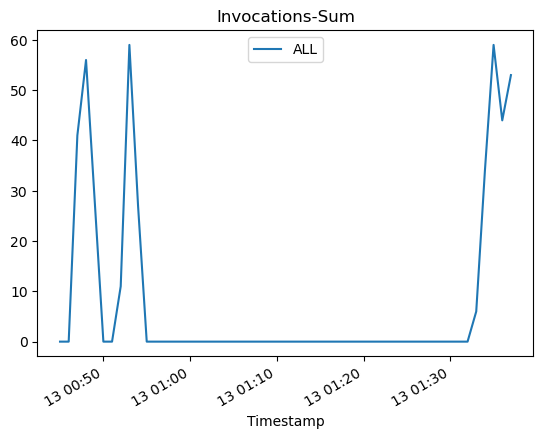

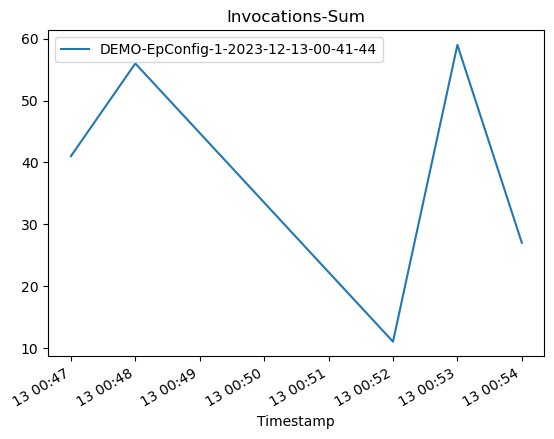

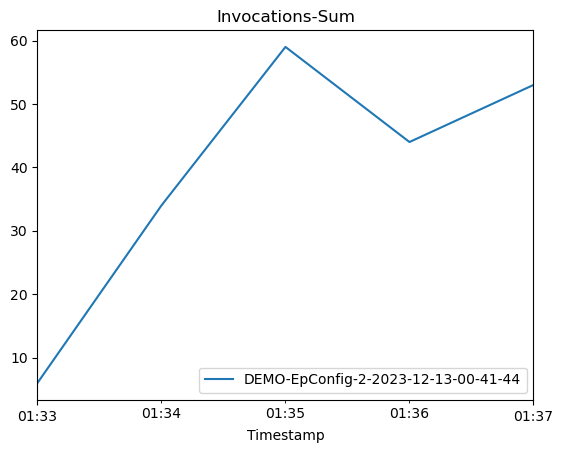

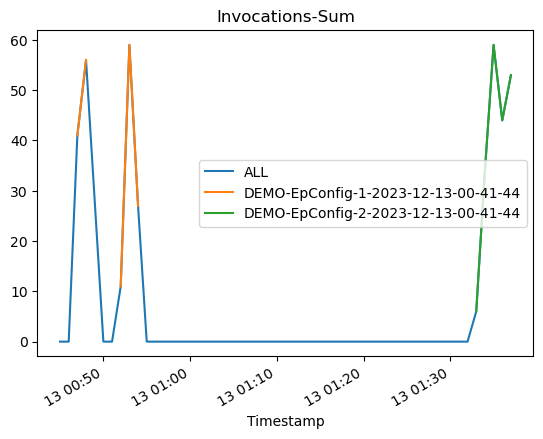

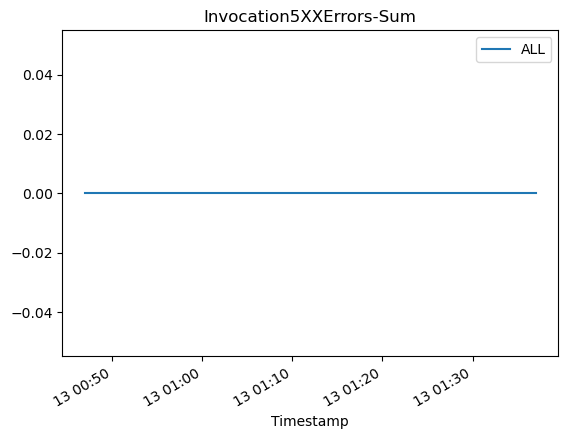

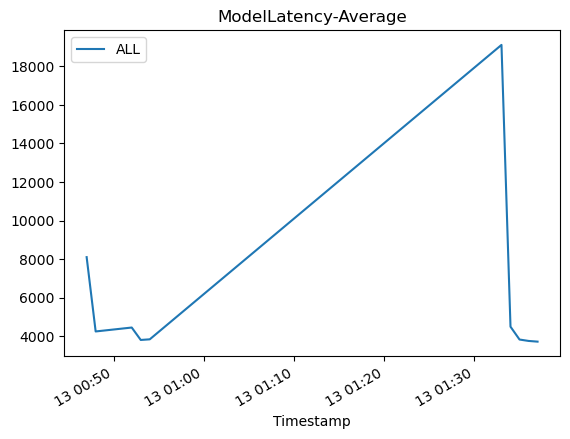

In [39]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)

metrics_all = invocation_metrics.join([metrics_epc_1, metrics_epc_2], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

In [49]:
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name3,
    RetainDeploymentConfig=True,
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/demo-deployment-guardrails-canary-2023-12-13-00-42-00',
 'ResponseMetadata': {'RequestId': '766c211e-4ed3-4003-9f6c-5176f40f1b6d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '766c211e-4ed3-4003-9f6c-5176f40f1b6d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Wed, 13 Dec 2023 01:56:24 GMT'},
  'RetryAttempts': 0}}

In [50]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/demo-deployment-guardrails-canary-2023-12-13-00-42-00',
 'EndpointConfigName': 'DEMO-EpConfig-3-2023-12-13-00-41-44',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:ebb5ca517c1568776383de018e4c2d46e8b934284d40b9d2ddf5c2e37424c929',
     'ResolutionTime': datetime.datetime(2023, 12, 13, 1, 56, 26, 155000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 12, 13, 0, 42, 0, 404000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 12, 13, 2, 6, 58, 834000, tzinfo=tzlocal()),
 'LastDep

In [53]:
invoke_endpoint(endpoint_name, max_invocations=500)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2023-12-13-00-42-00. 
Please wait...
.................................................................................................
Done!


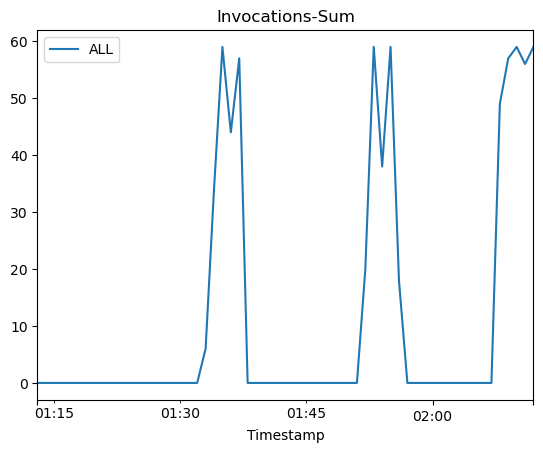

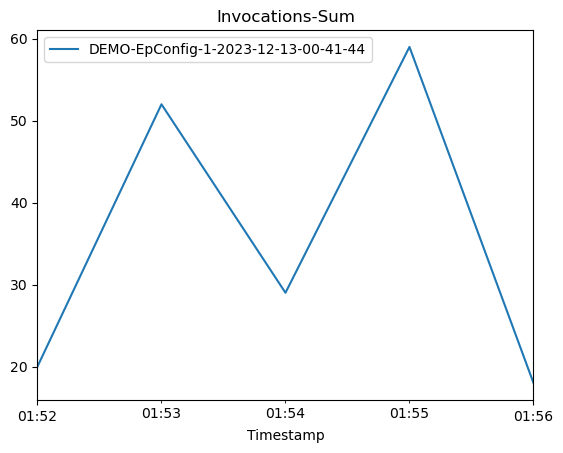

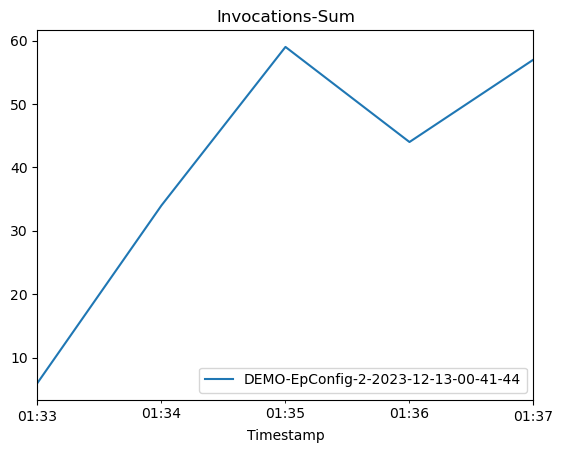

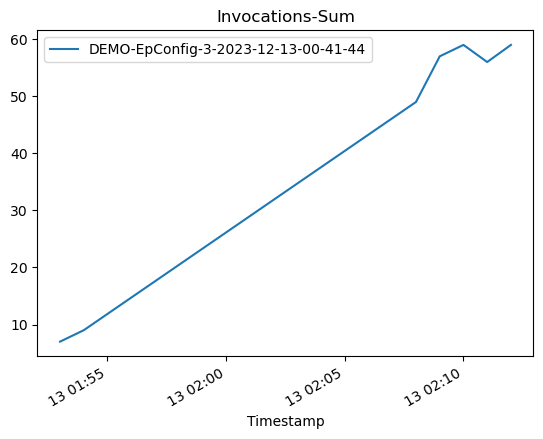

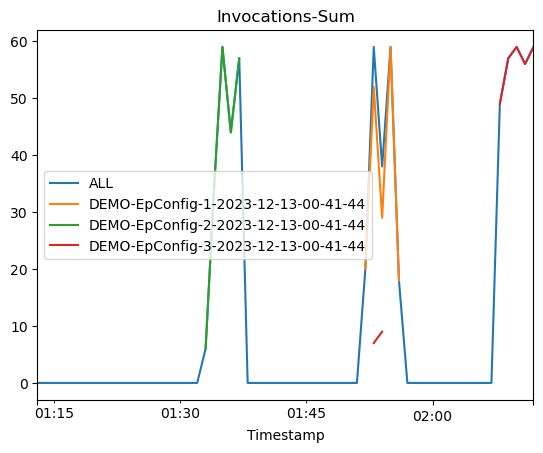

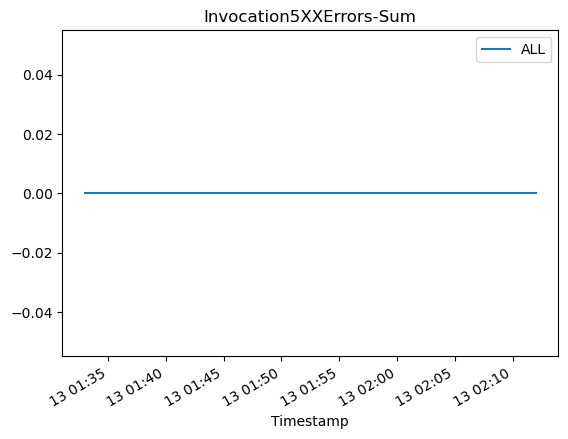

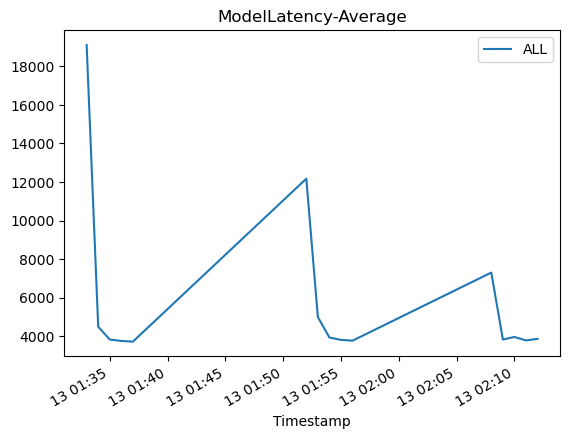

In [54]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_3 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name3, "AllTraffic", "Invocations", "Sum"
)

metrics_all = invocation_metrics.join([metrics_epc_1, metrics_epc_2, metrics_epc_3], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

Shadow testing

In [96]:
shadow_ep_config_name = f"Shadow-EpConfig-{datetime.now():%Y-%m-%d-%H-%M-%S}"
production_variant_name = "production"
shadow_variant_name = "shadow"
 
create_shadow_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=shadow_ep_config_name,
    ProductionVariants=[
        {
            "VariantName": production_variant_name,
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 2,
            "InitialVariantWeight": 1,
        }
    ],
    ShadowProductionVariants=[
        {
            "VariantName": shadow_variant_name,
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 0.5,
        }
    ],
)
print(f"Created EndpointConfig: {create_shadow_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-east-1:692885108950:endpoint-config/shadow-epconfig-2023-12-13-06-27-07


In [97]:
shadow_endpoint_name = f"linear-learner-prod-shadow-{datetime.now():%Y-%m-%d-%H-%M-%S}"
create_endpoint_api_response = sm.create_endpoint(
    EndpointName=shadow_endpoint_name,
    EndpointConfigName=shadow_ep_config_name,
)

In [98]:
sm.describe_endpoint(EndpointName=shadow_endpoint_name)

{'EndpointName': 'linear-learner-prod-shadow-2023-12-13-06-27-11',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/linear-learner-prod-shadow-2023-12-13-06-27-11',
 'EndpointConfigName': 'Shadow-EpConfig-2023-12-13-06-27-07',
 'ProductionVariants': [{'VariantName': 'production',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:ebb5ca517c1568776383de018e4c2d46e8b934284d40b9d2ddf5c2e37424c929',
     'ResolutionTime': datetime.datetime(2023, 12, 13, 6, 27, 12, 883000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 2,
   'DesiredInstanceCount': 2}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 12, 13, 6, 27, 11, 894000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 12, 13, 6, 30, 28, 869000, tzinfo=tzlocal()),
 'ShadowProductionVar

In [101]:
def invoke_endpoint(endpoint_name, should_raise_exp=False):
    with open("test_data/test-dataset.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                for i in range(10):
                    response = sm_runtime.invoke_endpoint(
                        EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                    )
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e
 
 
invoke_endpoint(shadow_endpoint_name)

In [102]:
import pandas as pd
 
cw = boto3.Session().client("cloudwatch", region_name=region)
  
def get_sagemaker_metrics_shadow(
    endpoint_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    namespace = "AWS/SageMaker"
    if metric_name in ["CPUUtilization", "MemoryUtilization", "DiskUtilization"]:
        namespace = "/aws/sagemaker/Endpoints"
 
    metrics = cw.get_metric_statistics(
        Namespace=namespace,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=1,
        Statistics=[statistic],
        Dimensions=dimensions,
    )
 
    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: variant_name})
    )

 
def plot_endpoint_invocation_metrics_shadow(
    endpoint_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=10)
    end_time = datetime.now(timezone.utc)
    metrics_production = get_sagemaker_metrics(
        endpoint_name,
        production_variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    metrics_shadow = get_sagemaker_metrics(
        endpoint_name,
        shadow_variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    try:
        metrics_variants = pd.merge(metrics_production, metrics_shadow, on="Timestamp")
        return metrics_variants.plot(y=["production", "shadow"])
    except Exception as e:
        print(e)

In [105]:
CPUUtilization = plot_endpoint_invocation_metrics_shadow(shadow_endpoint_name,"CPUUtilization", "Sum")
invocations_per_instance = plot_endpoint_invocation_metrics_shadow(shadow_endpoint_name, "InvocationsPerInstance", "Sum")

TypeError: get_sagemaker_metrics() missing 1 required positional argument: 'end_time'

In [93]:
memoryUtilization = plot_endpoint_invocation_metrics_shadow(shadow_endpoint_name, "MemoryUtilization", "Sum")

TypeError: get_sagemaker_metrics() missing 1 required positional argument: 'end_time'

In [94]:
modelLatency=plot_endpoint_invocation_metrics_shadow(shadow_endpoint_name,"ModelLatency","Sum")

TypeError: get_sagemaker_metrics() missing 1 required positional argument: 'end_time'

In [95]:
DiskUtilization = plot_endpoint_invocation_metrics_shadow(shadow_endpoint_name, "DiskUtilization", "Sum")

TypeError: get_sagemaker_metrics() missing 1 required positional argument: 'end_time'

In [ ]:
invocations = plot_endpoint_invocation_metrics_shadow(shadow_endpoint_name, "Invocations", "Sum")
invocations_per_instance = plot_endpoint_invocation_metrics_shadow(
    shadow_endpoint_name, "InvocationsPerInstance", "Sum"
)

In [107]:
promote_ep_config_name = f"PromoteShadow-EpConfig-{datetime.now():%Y-%m-%d-%H-%M-%S}"
 
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=promote_ep_config_name,
    ProductionVariants=[
        {
            "VariantName": shadow_variant_name,
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 2,
            "InitialVariantWeight": 1.0,
        }
    ],
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-east-1:692885108950:endpoint-config/promoteshadow-epconfig-2023-12-13-06-40-10


In [108]:
update_endpoint_api_response = sm.update_endpoint(
    EndpointName=shadow_endpoint_name,
    EndpointConfigName=promote_ep_config_name,
)
 
wait_for_endpoint_in_service(shadow_endpoint_name)

Waiting for endpoint in service
.......
Done!


In [109]:
sm.describe_endpoint(EndpointName=shadow_endpoint_name)

{'EndpointName': 'linear-learner-prod-shadow-2023-12-13-06-27-11',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:692885108950:endpoint/linear-learner-prod-shadow-2023-12-13-06-27-11',
 'EndpointConfigName': 'PromoteShadow-EpConfig-2023-12-13-06-40-10',
 'ProductionVariants': [{'VariantName': 'shadow',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:ebb5ca517c1568776383de018e4c2d46e8b934284d40b9d2ddf5c2e37424c929',
     'ResolutionTime': datetime.datetime(2023, 12, 13, 6, 40, 14, 842000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 2,
   'DesiredInstanceCount': 2}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 12, 13, 6, 27, 11, 894000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 12, 13, 6, 43, 35, 847000, tzinfo=tzlocal()),
 'ResponseMetadata